In [1]:
import torch
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_mnist_digits(batches, output=True, file='reconstr.pdf'):
    file = '/Users/as/astapleton_phd/dsb/subtle_diffusion/correlators/figs/' + file
    batches_to_plot = 5

    batch_size = len(batches[0])
    print('Batch size:', batch_size)

    num_digits = len(batches[0]) * batches_to_plot
    print('Num digits: ', num_digits)
    
    batches = batches[:batches_to_plot]
    # Create a grid of subplots with 20 rows and 20 columns
    fig, axes = plt.subplots(nrows=5, ncols=16, figsize=(20, 20))
    # fig, axes = plt.subplots(num_digits, 20, figsize=(20, 20))

    # Flatten the axes array to access the individual subplots easily
    axes = axes.flatten()

    # batches = [batches[i:i+784] for i in range(0, len(batch_correl_list), 784)]

    for batch_number, batch in enumerate(batches):
        for i, digit in enumerate(batch):
            # Convert Torch tensor to a NumPy array and reshape it to (28, 28)
            digit_np = digit.view(28, 28).detach().numpy()

            # Plot the digit using matplotlib
            axes[batch_number*batch_size + i].imshow(digit_np, cmap='gray')
            axes[batch_number*batch_size + i].axis('off')

    # # Remove any remaining empty subplots
    # for i in range(num_digits, 39):
    #     axes[i].axis('off')

    # plt.savefig(file)
    plt.show()
    

In [3]:
import matplotlib.pyplot as plt

# Define a function to calculate cross-entropy divergence
def mse_divergence(input_batch, output_batch):
    # Flatten the input and output batches
    input_flat = input_batch.view(-1)
    output_flat = output_batch.view(-1)
    
    # Compute the cross-entropy loss
    loss = F.mse_loss(output_flat, input_flat, reduction='mean')
    
    return loss

In [4]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## 1, 2 and 3pt functions

In [5]:
orig_images_3pt = torch.load('/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-1.0_3pt-0.017/batch_avg_approx_all_1pt_1.0-2pt_0.017-3pt_simpleout')
reconstructions_3pt = torch.load('/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-1.0_3pt-0.017/mixed_reconstr_avg_approx_all_1pt_1.0-2pt_0.017-3pt_simpleout')

Batch size: 16
Num digits:  80


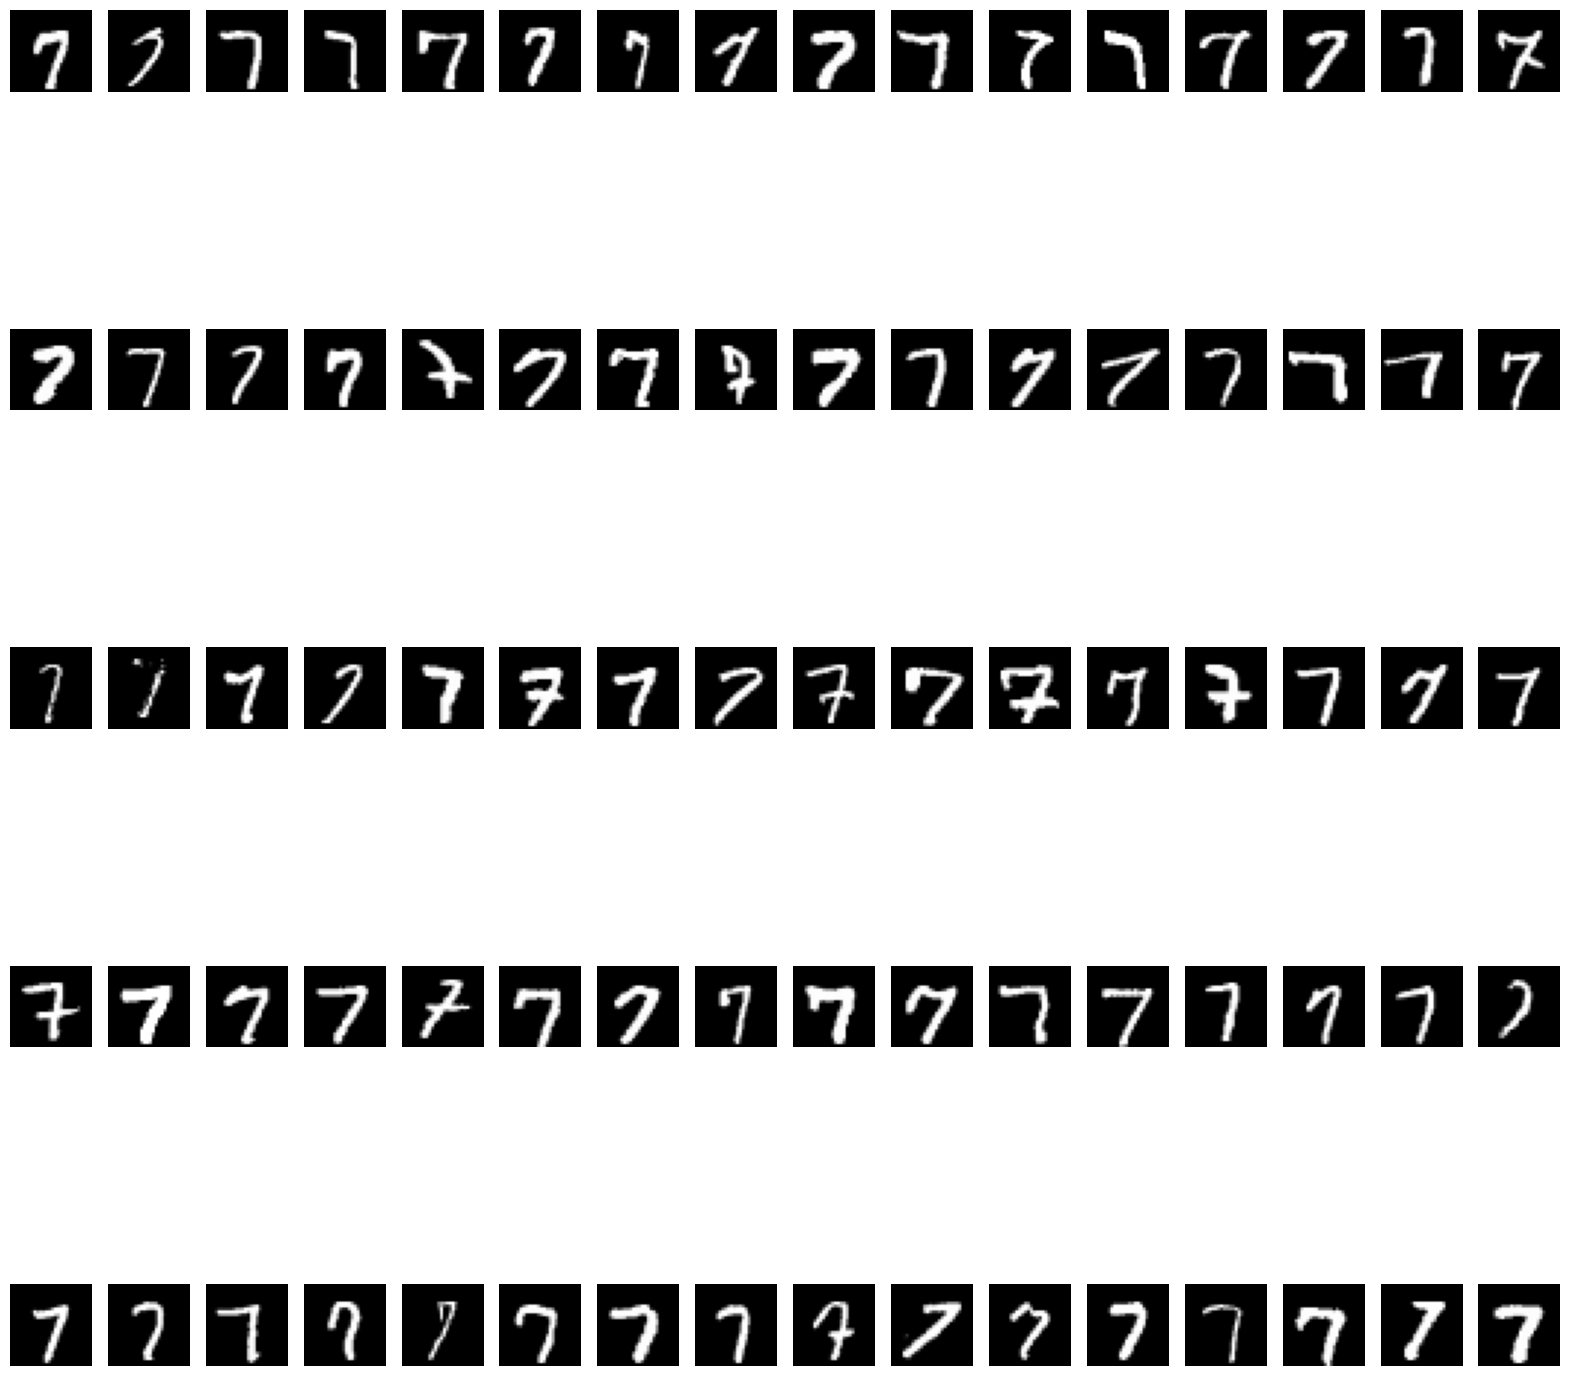

In [6]:
plot_mnist_digits(orig_images_3pt[500:])

In [7]:
new_reconstructions_3pt = []
for batch in reconstructions_3pt:
    tidied_batch = [batch[i:i+784] for i in range(0, len(batch), 784)]
    new_reconstructions_3pt.append(tidied_batch)
# reconstructions_2pt = new_reconstructions_2pt

Batch size: 16
Num digits:  80


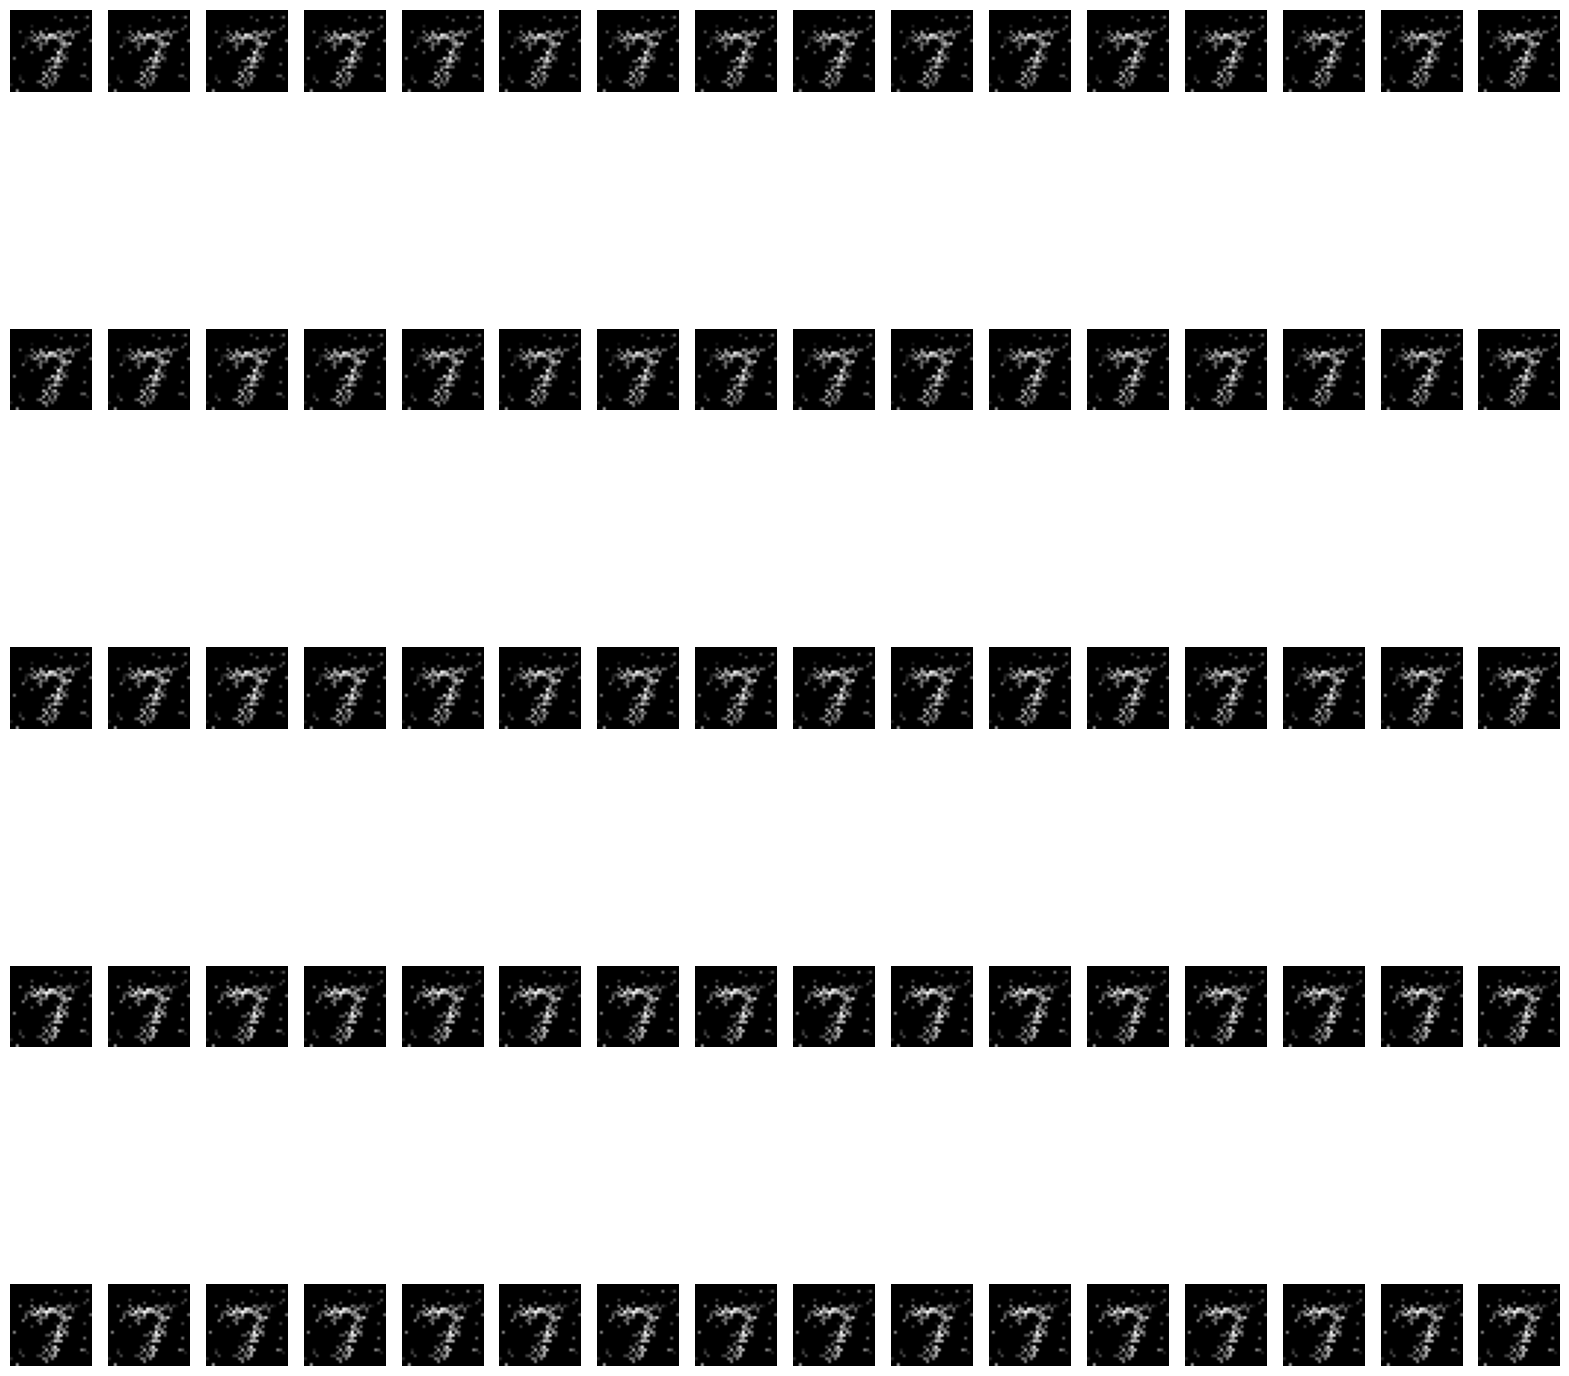

In [8]:
plot_mnist_digits(new_reconstructions_3pt[2200:])

In [9]:
# Test Gaussian blur
def gaussian_blur_mnist_digit(flattened_tensor, kernel_size=5, sigma=1.0):
    # Reshape the flattened tensor back to its original shape (28x28)
    image = flattened_tensor.view(28, 28).unsqueeze(0).float()

    # Apply Gaussian blur
    blurred_image = F.gaussian_blur(image, kernel_size, sigma)

    # Remove the extra batch dimension
    blurred_image = blurred_image.squeeze(0)

    # Flatten the blurred image back to a tensor
    blurred_tensor = blurred_image.view(-1)

    return blurred_tensor

In [10]:
def plot_flattened_mnist_digit(flattened_digit):
    # Reshape the flattened tensor to its original shape (28x28)
    image = flattened_digit.view(28, 28)

    # Plot the digit
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

### Losses (Training) - 1,2&3pt

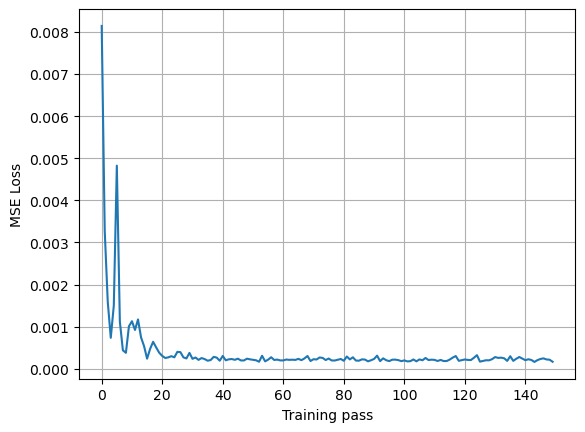

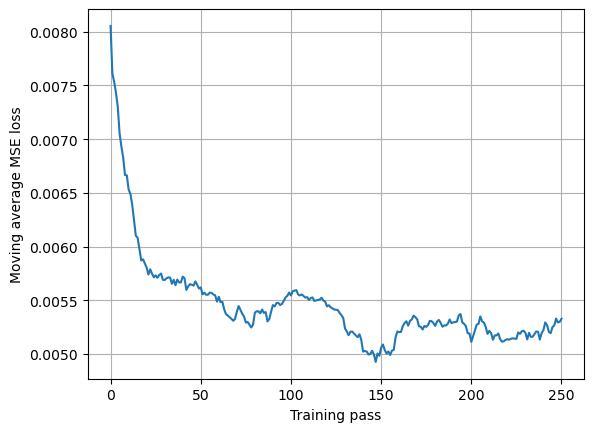

In [11]:
# Step 1: Load the tensor from the saved file
file_path = '/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-1_3pt-0.01/loss_hist_all_1pt_1.0-2pt_0.01-3pt_simpleout'  # Replace with the path to your saved tensor file
loaded_tensor = torch.load(file_path)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(loaded_tensor[:150])
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
# plt.title('MSE training loss for 1,2,3pt cumulant decoder')
plt.grid(True)
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/dec_training_loss_123-1_1_0.017.pdf')
plt.show()


# Step 1: Load the tensor from the saved file
file_path = '/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-1_3pt-0.01/enc_loss_hist'  # Replace with the path to your saved tensor file
loaded_tensor = torch.load(file_path)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(moving_average(loaded_tensor[:350], 50))
plt.xlabel('Training pass')
plt.ylabel('Moving average MSE loss')
# plt.title('MSE training loss for 1&2pt cumulant encoder')
plt.grid(True)
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/enc_training_loss_123-1_1_0.017.pdf')
plt.show()

### Losses (Validation)

In [12]:
# Notice that the reconstructions are the same tensor repeated |B| times, so we can MSE loss this straight away
mse_321 = []
mse_loss = torch.nn.MSELoss()
for train_pass in range(2000, 2300):
    flattened_orig_batch = orig_images_3pt[train_pass].flatten()
    flattened_reconstr = torch.concatenate(new_reconstructions_3pt[train_pass], axis=0)
    mse_321.append(mse_loss(flattened_orig_batch, flattened_reconstr))
print(sum(mse_321)/len(mse_321))


tensor(0.0836)


 ## 1pt and 2pt functions

In [13]:
orig_images_2pt = torch.load('/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-1-3pt_0.0_doover/batch_avg_approx_all_1pt_1.0-2pt_0.0-3pt_simpleout')
reconstructions_2pt = torch.load('/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-1-3pt_0.0_doover/mixed_reconstr_avg_approx_all_1pt_1.0-2pt_0.0-3pt_simpleout')
len(reconstructions_2pt)
# stiff_reconstructions = torch.load('/home/as/astapleton_phd/dsb/subtle_diffusion/correlators/correlator_nn/reconstr/stiff_reconstr_avg_approx')

2400

Batch size: 16
Num digits:  80


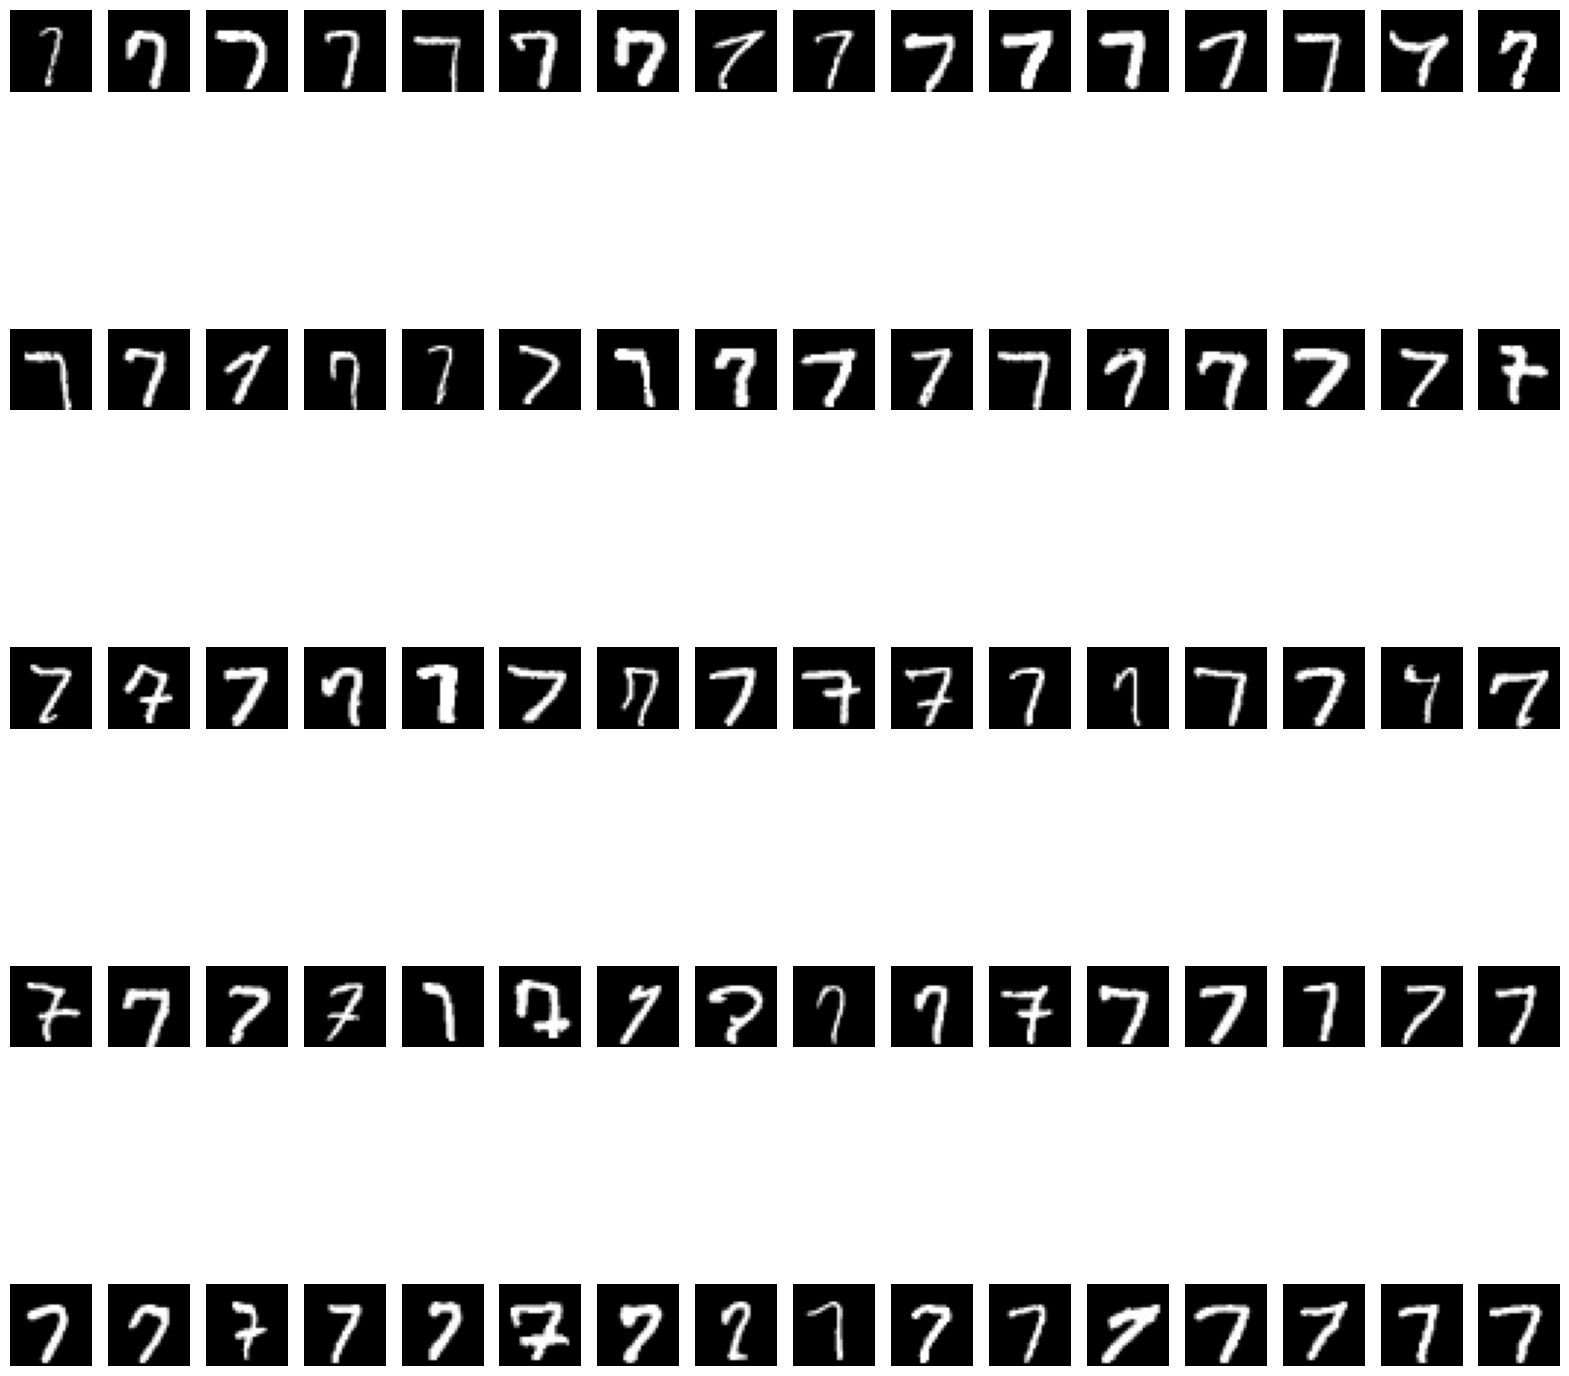

In [14]:
plot_mnist_digits(orig_images_2pt)

In [15]:
new_reconstructions_2pt = []
for batch in reconstructions_2pt:
    tidied_batch = [batch[i:i+784] for i in range(0, len(batch), 784)]
    new_reconstructions_2pt.append(tidied_batch)
# reconstructions_2pt = new_reconstructions_2pt

Batch size: 16
Num digits:  80


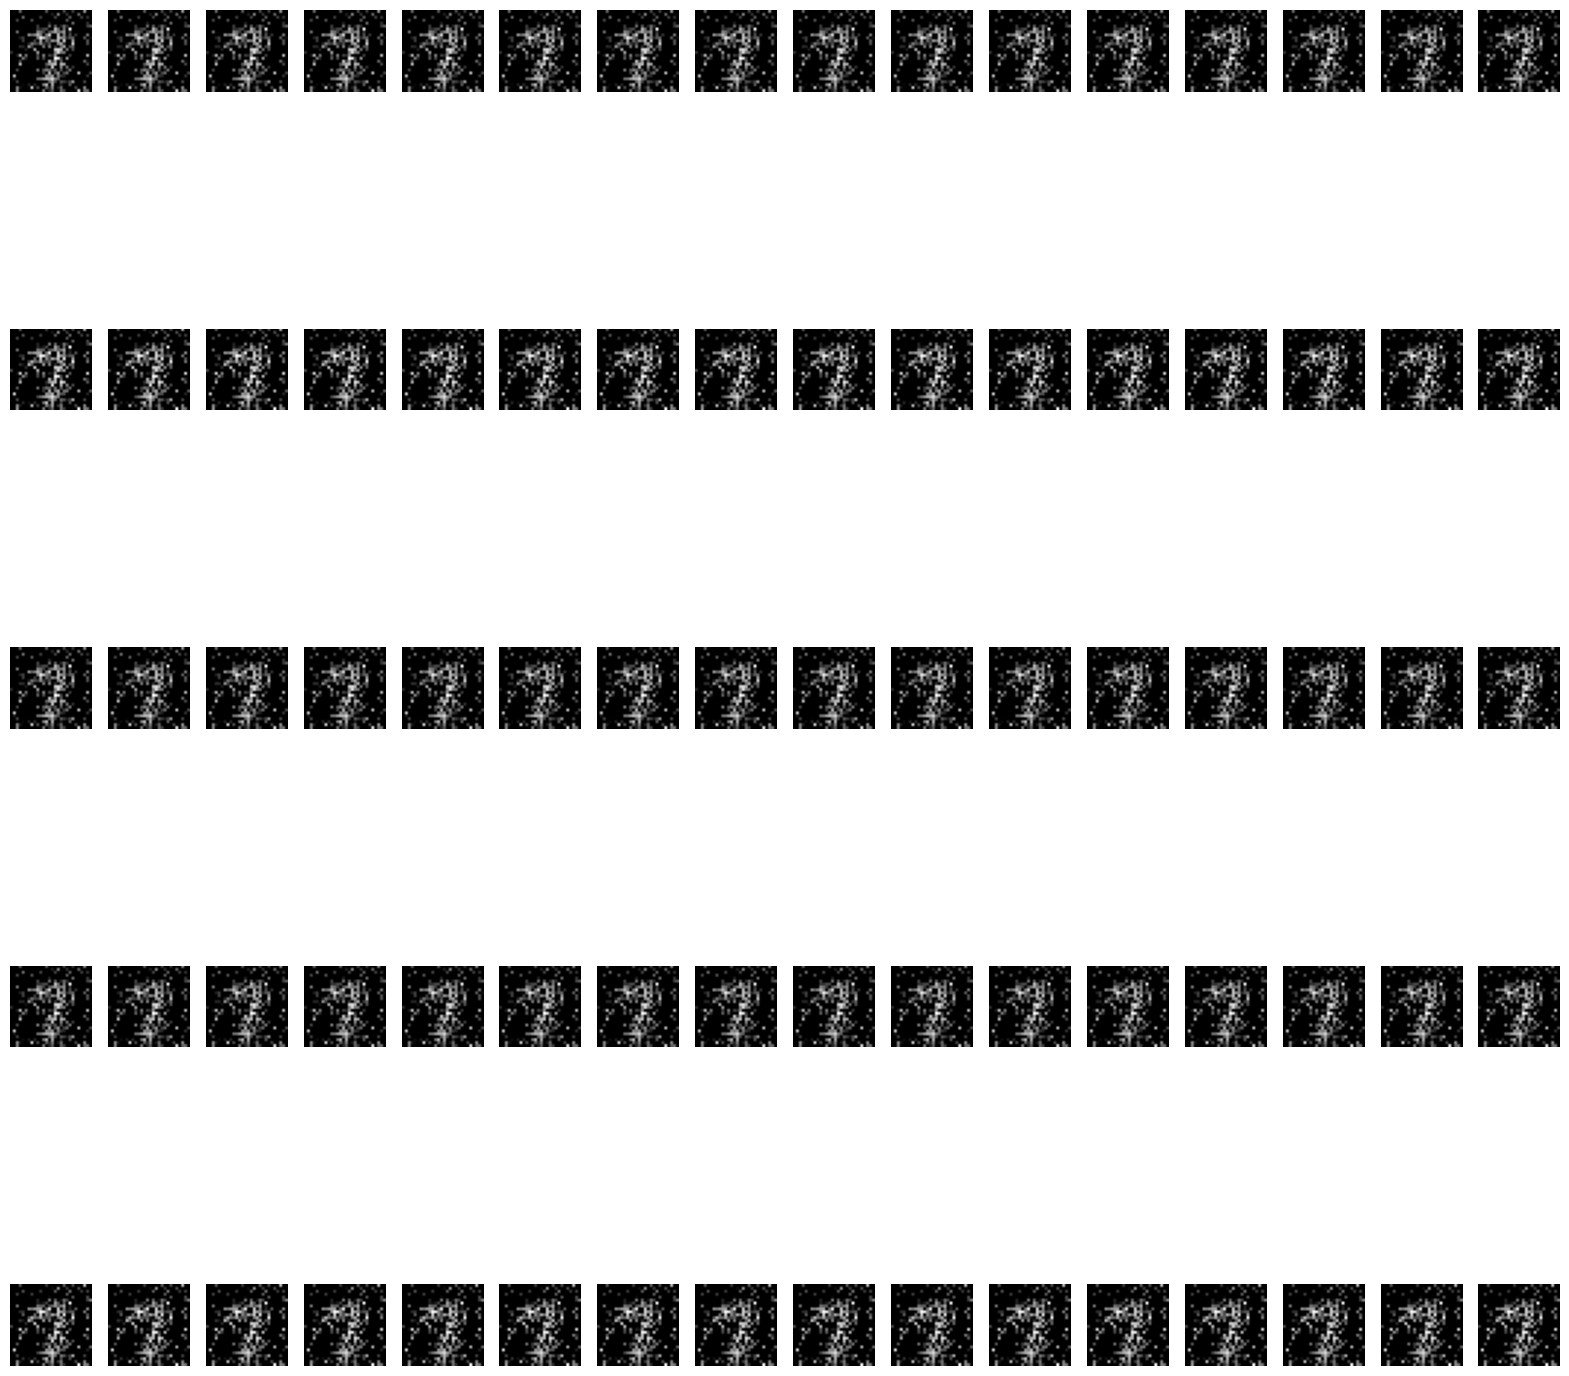

In [16]:
plot_mnist_digits(new_reconstructions_2pt[2300:])

### Losses (Training) - 1&2pt

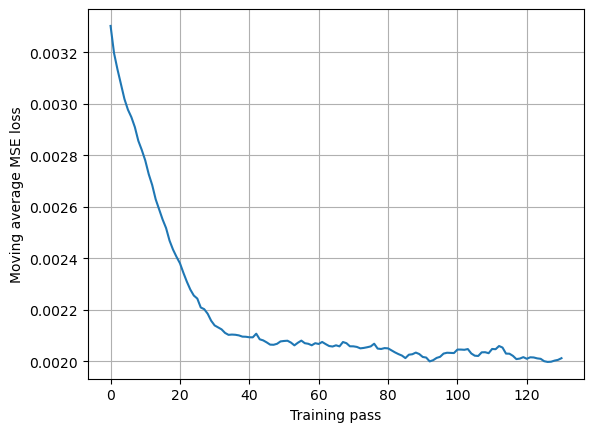

In [17]:
# Step 1: Load the tensor from the saved file
file_path = '/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-1-3pt_0.0_doover/enc_loss_hist'  # Replace with the path to your saved tensor file
loaded_tensor = torch.load(file_path)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(moving_average(loaded_tensor[:180], 50))
plt.xlabel('Training pass')
plt.ylabel('Moving average MSE loss')
# plt.title('MSE training loss for 1&2pt cumulant encoder')
plt.grid(True)
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/enc_training_loss_123-1_1_0.pdf')
plt.show()

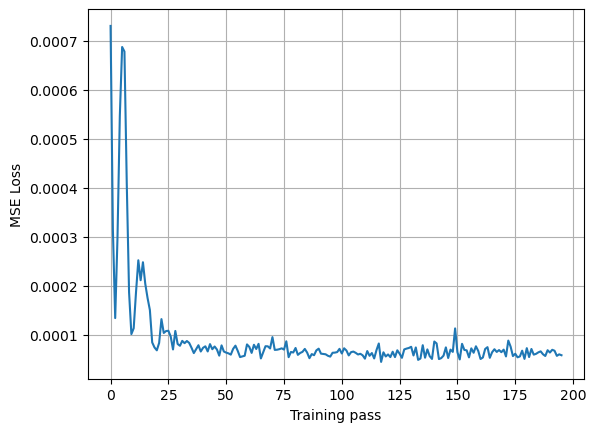

In [18]:
# Step 1: Load the tensor from the saved file
file_path = '/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-1-3pt_0.0/loss_hist_all_1pt_1.0-2pt_0.0-3pt_simpleout'  # Replace with the path to your saved tensor file
loaded_tensor = torch.load(file_path)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(moving_average(loaded_tensor[4:200], 1))
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
# plt.title('MSE training loss for 1&2pt cumulant decoder')
plt.grid(True)
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/dec_training_loss_123-1_1_0.0.pdf')
plt.show()


### Losses (Validation)

In [19]:
# Notice that the reconstructions are the same tensor repeated |B| times, so we can MSE loss this straight away
mse_21 = []
mse_loss = torch.nn.MSELoss()
for train_pass in range(2000, 2300):
    flattened_orig_batch = orig_images_2pt[train_pass].flatten()
    flattened_reconstr = torch.concatenate(new_reconstructions_2pt[train_pass], axis=0)
    mse_21.append(mse_loss(flattened_orig_batch, flattened_reconstr))
print(sum(mse_21)/len(mse_21))

tensor(0.0990)


## 1 and 3pt functions

In [20]:
orig_images_13pt = torch.load('/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-0.0_3pt-0.017/batch_avg_approx_all_1pt_0.0-2pt_0.017-3pt_simpleout')
reconstructions_13pt = torch.load('/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-0.0_3pt-0.017/mixed_reconstr_avg_approx_all_1pt_0.0-2pt_0.017-3pt_simpleout')
len(reconstructions_13pt)

2400

Batch size: 16
Num digits:  80


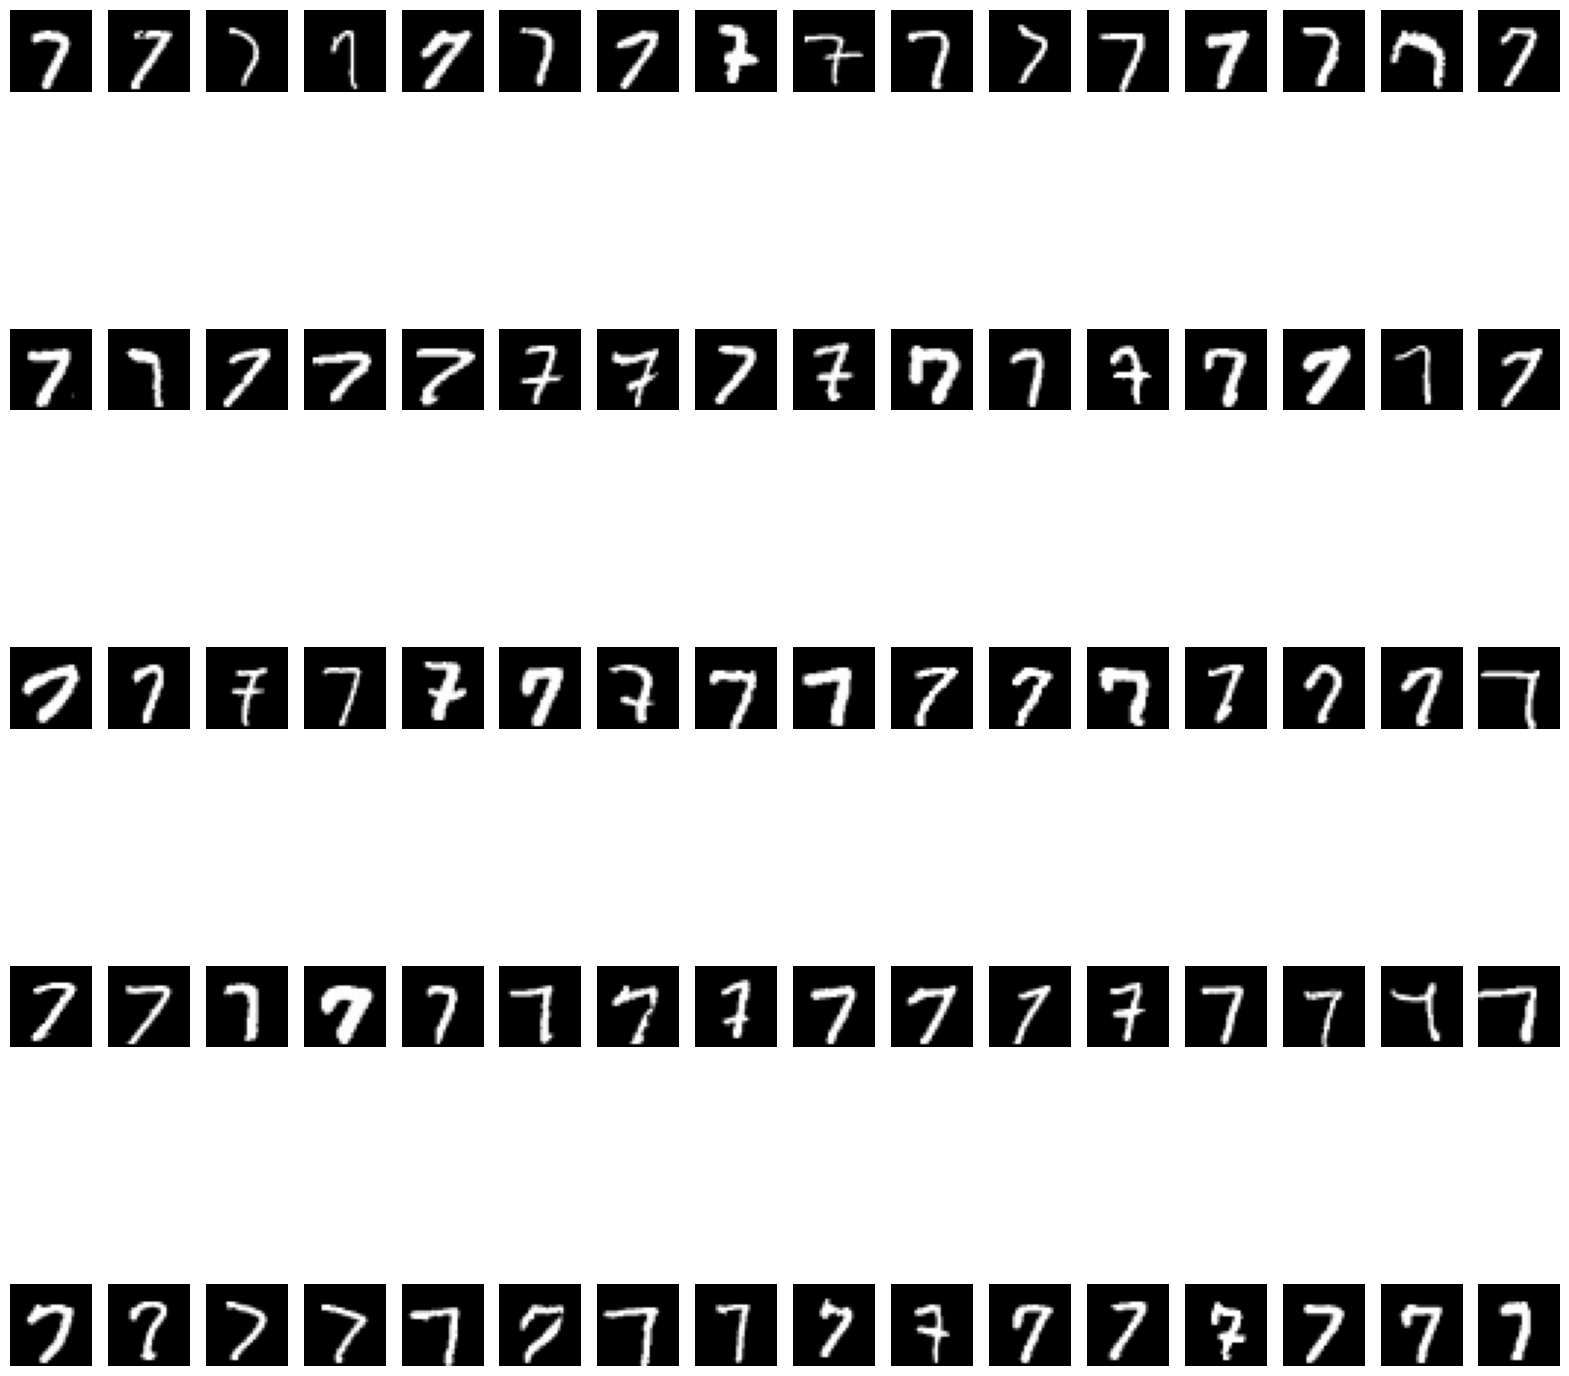

In [21]:
plot_mnist_digits(orig_images_13pt)

In [22]:
new_reconstructions_13pt = []
for batch in reconstructions_13pt:
    tidied_batch = [batch[i:i+784] for i in range(0, len(batch), 784)]
    new_reconstructions_13pt.append(tidied_batch)

Batch size: 16
Num digits:  80


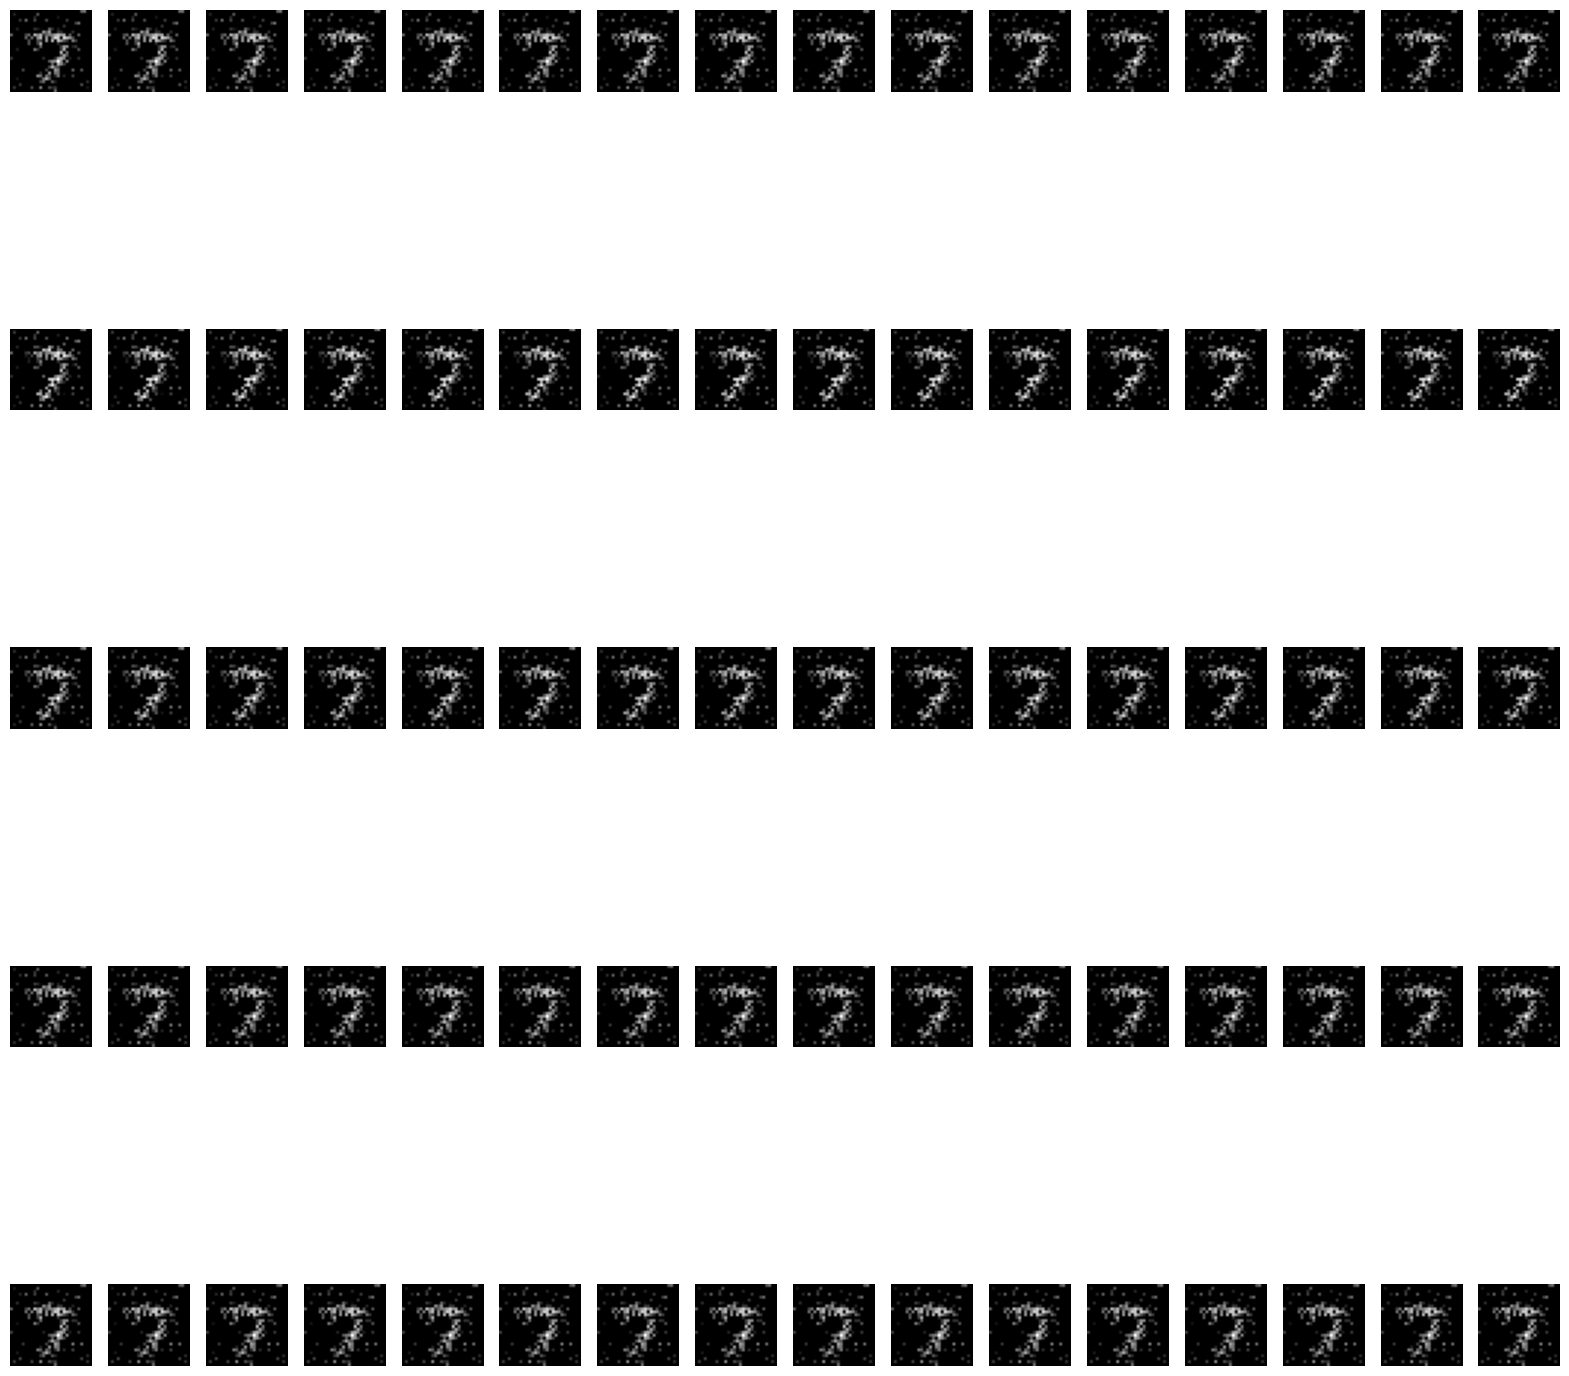

In [23]:
plot_mnist_digits(new_reconstructions_13pt[900:])

### Losses (Training) 1 and 3 pt

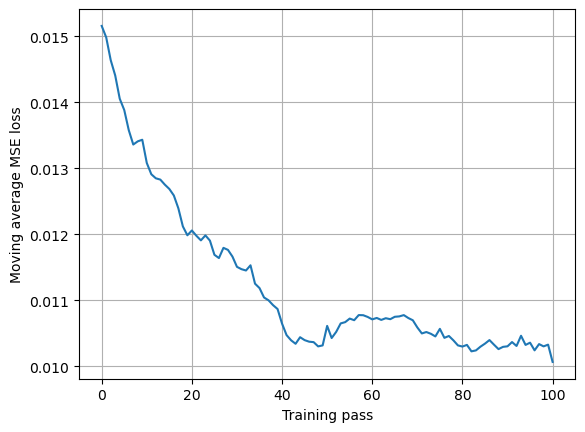

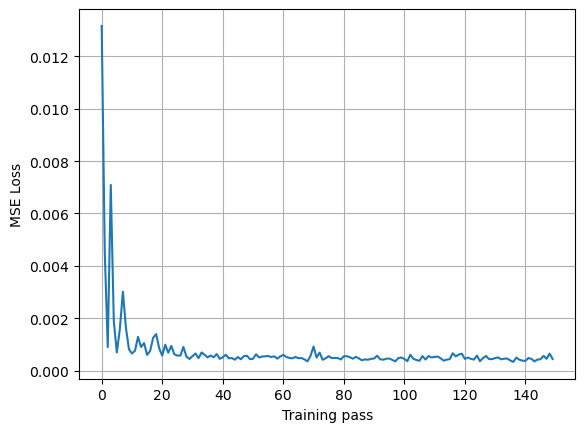

In [24]:
# Step 1: Load the tensor from the saved file
file_path = '/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-0.0_3pt-0.017/enc_loss_hist'  # Replace with the path to your saved tensor file
loaded_tensor = torch.load(file_path)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(moving_average(loaded_tensor[:150], 50))
plt.xlabel('Training pass')
plt.ylabel('Moving average MSE loss')
# plt.title('MSE training loss for 1&2pt cumulant encoder')
plt.grid(True)
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/enc_training_loss_123-1_0_0.017.pdf')
plt.show()


# Step 1: Load the tensor from the saved file
file_path = '/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-0.0_3pt-0.017/loss_hist_all_1pt_0.0-2pt_0.017-3pt_simpleout'
loaded_tensor = torch.load(file_path)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(loaded_tensor[:150])
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
# plt.title('MSE training loss for 1 and 3 point cumulant decoder')
plt.grid(True)
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/dec_training_loss_123-1_0_0.017.pdf')
plt.show()

### Losses (Validation) -- 1 and 3 point

In [25]:
# Notice that the reconstructions are the same tensor repeated |B| times, so we can MSE loss this straight away
mse_13 = []
mse_loss = torch.nn.MSELoss()
for train_pass in range(2000, 2300):
    flattened_orig_batch = orig_images_13pt[train_pass].flatten()
    flattened_reconstr = torch.concatenate(new_reconstructions_13pt[train_pass], axis=0)
    mse_13.append(mse_loss(flattened_orig_batch, flattened_reconstr))
print(sum(mse_13)/len(mse_13))

tensor(0.0851)


## 1pt only

In [26]:
orig_images_1pt = torch.load('/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-0.0_3pt-0.0/batch_avg_approx_all_1pt_0.0-2pt_0.0-3pt_simpleout')
reconstructions_1pt = torch.load('/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-0.0_3pt-0.0/mixed_reconstr_avg_approx_all_1pt_0.0-2pt_0.0-3pt_simpleout')

Batch size: 16
Num digits:  80


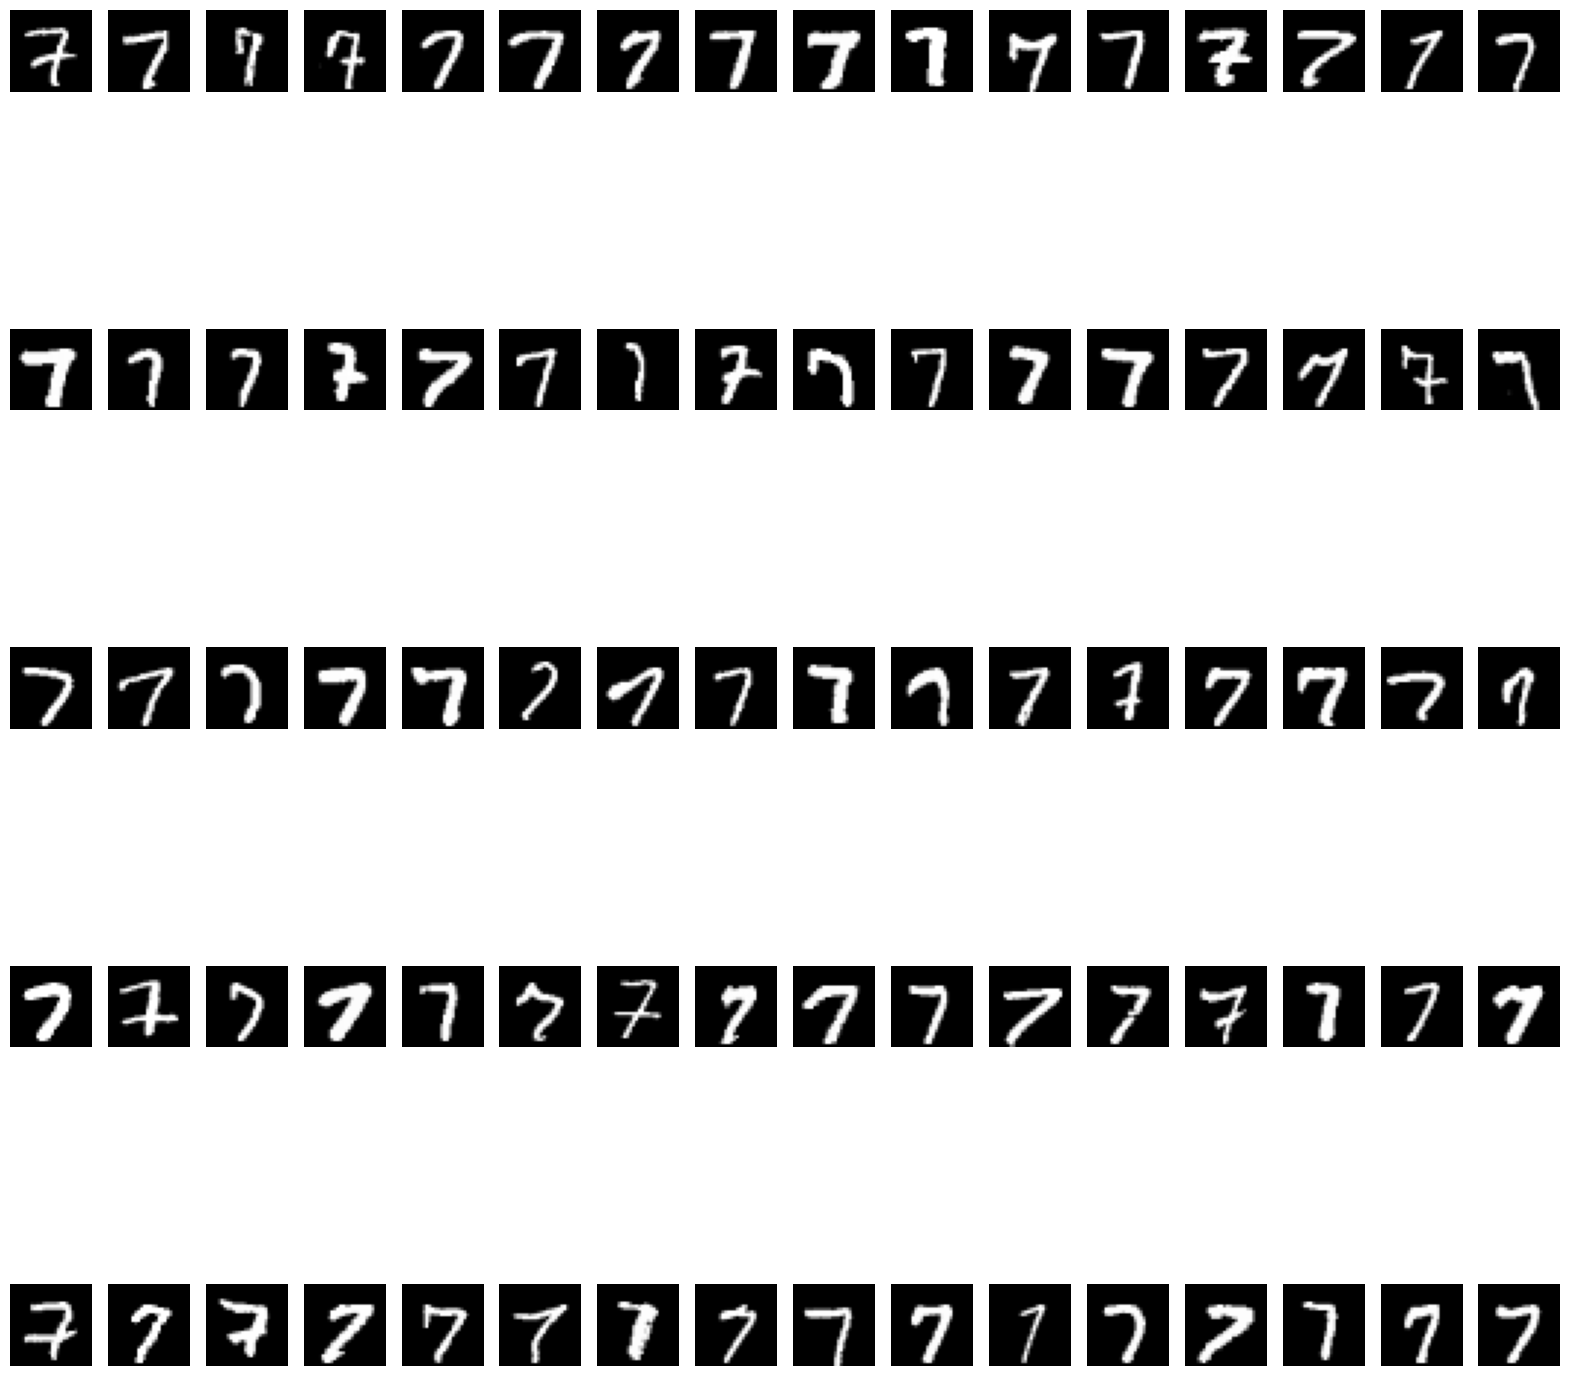

In [27]:
plot_mnist_digits(orig_images_1pt)

In [28]:
new_reconstructions_1pt = []
for batch in reconstructions_1pt:
    tidied_batch = [batch[i:i+784] for i in range(0, len(batch), 784)]
    new_reconstructions_1pt.append(tidied_batch)
# reconstructions_2pt = new_reconstructions_2pt

Batch size: 16
Num digits:  80


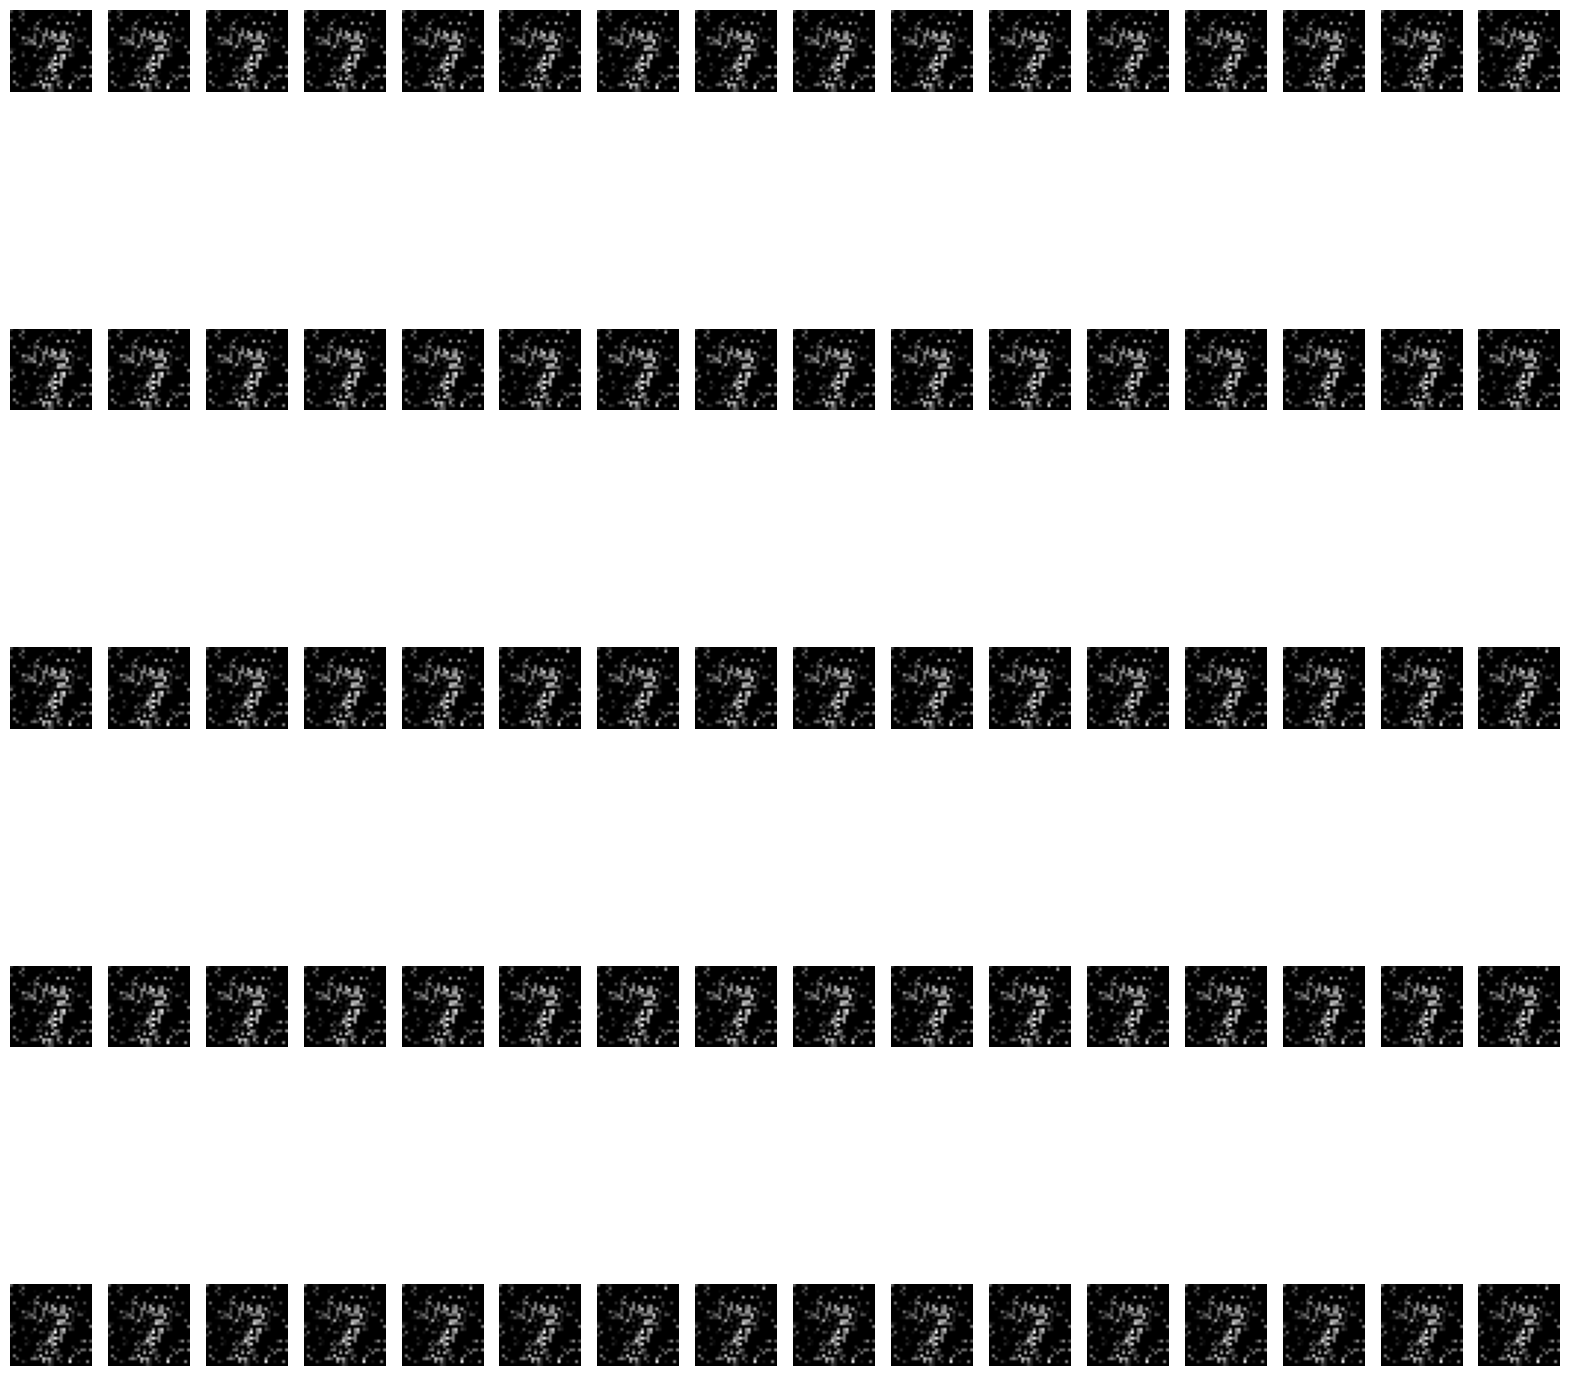

In [29]:
plot_mnist_digits(new_reconstructions_1pt[900:])

### Losses (Training) -- 1pt Only

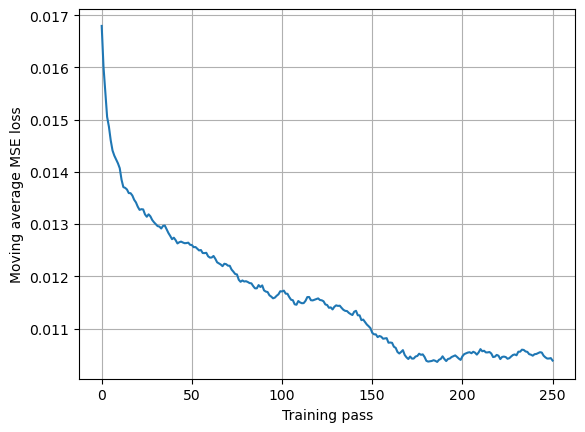

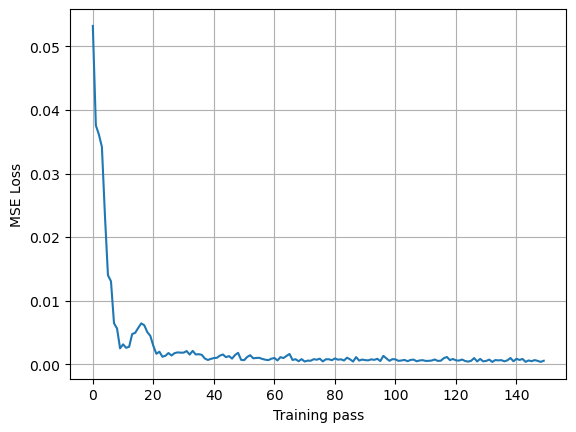

In [30]:
# Step 1: Load the tensor from the saved file
file_path = '/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-0.0_3pt-0.0/enc_loss_hist'  # Replace with the path to your saved tensor file
loaded_tensor = torch.load(file_path)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(moving_average(loaded_tensor[:300], 50))
plt.xlabel('Training pass')
plt.ylabel('Moving average MSE loss')
# plt.title('MSE training loss for 1&2pt cumulant encoder')
plt.grid(True)
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/enc_training_loss_123-1_0_0.pdf')
plt.show()



# Step 1: Load the tensor from the saved file
file_path = '/Users/as/Desktop/reconstructions/MNIST/bs16/lr_0.0001/2pt-0.0_3pt-0.0/loss_hist_all_1pt_0.0-2pt_0.0-3pt_simpleout'  # Replace with the path to your saved tensor file
loaded_tensor = torch.load(file_path)

# Step 2: Convert the tensor to a NumPy array
# numpy_array = loaded_tensor.numpy()

# Step 3: Plot the data using Matplotlib
plt.plot(loaded_tensor[0:150])
plt.xlabel('Training pass')
plt.ylabel('MSE Loss')
# plt.title('MSE training loss for 1 only cumulant decoder')
plt.grid(True)
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/dec_training_loss_123-1_0_0.0.pdf')
plt.show()

### Losses (Validation)

In [31]:
# Notice that the reconstructions are the same tensor repeated |B| times, so we can MSE loss this straight away
mse_1 = []
mse_loss = torch.nn.MSELoss()
for train_pass in range(2000, 2300):
    flattened_orig_batch = orig_images_1pt[train_pass].flatten()
    flattened_reconstr = torch.concatenate(new_reconstructions_1pt[train_pass], axis=0)
    mse_1.append(mse_loss(flattened_orig_batch, flattened_reconstr))
print(sum(mse_1)/len(mse_1))

tensor(0.1361)


### Combined MSE losses (val)

In [32]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

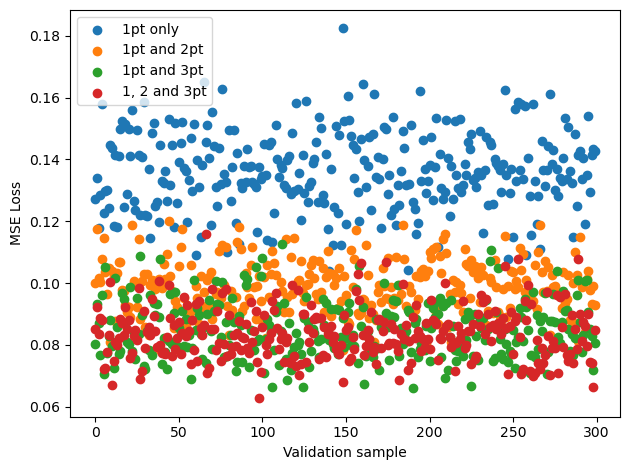

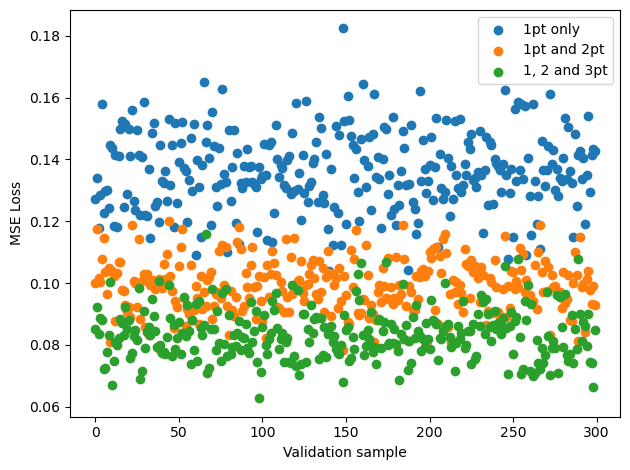

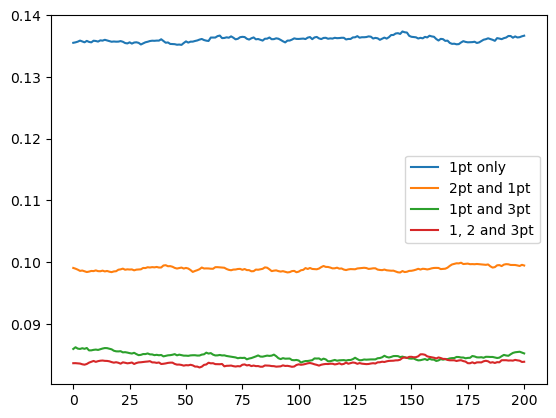

In [33]:
# Combined MSE validation
grainer = 1

plt.scatter(range(len(moving_average(mse_1, grainer))), moving_average(mse_1, grainer), label='1pt only')
plt.scatter(range(len(moving_average(mse_21, grainer))), moving_average(mse_21, grainer), label='1pt and 2pt')
plt.scatter(range(len(moving_average(mse_13, grainer))), moving_average(mse_13, grainer), label='1pt and 3pt')
plt.scatter(range(len(moving_average(mse_321, grainer))), moving_average(mse_321, grainer), label='1, 2 and 3pt')
plt.xlabel('Validation sample')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/loss_trifle_all.pdf')
plt.show()


plt.scatter(range(len(moving_average(mse_1, grainer))), moving_average(mse_1, grainer), label='1pt only')
plt.scatter(range(len(moving_average(mse_21, grainer))), moving_average(mse_21, grainer), label='1pt and 2pt')
# plt.scatter(range(len(moving_average(mse_13, grainer))), moving_average(mse_13, grainer), label='1pt and 3pt')
plt.scatter(range(len(moving_average(mse_321, grainer))), moving_average(mse_321, grainer), label='1, 2 and 3pt')
plt.xlabel('Validation sample')
plt.ylabel('MSE Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/as/astapleton_phd/dsb/papers/cumulant_encoder/figs/since_iaifi/final/MNIST/loss_trifle_no_13.pdf')
plt.show()


plt.plot(moving_average(mse_1, 100), label='1pt only')
plt.plot(moving_average(mse_21, 100), label='2pt and 1pt')
plt.plot(moving_average(mse_13, 100), label='1pt and 3pt')
plt.plot(moving_average(mse_321, 100), label='1, 2 and 3pt')
plt.legend()
plt.show()